# **Using Multi-modal Neural Network for movie genres classification**

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import cv2
from torchvision import transforms, utils
from torchvision import models

from nltk import wordpunct_tokenize
import re

from transformers import AutoTokenizer, AutoModel

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

os.environ["TOKENIZERS_PARALLELISM"] = "true"

data_dir = '/kaggle/input/cerenote/content/dataset'
support_dir = '/kaggle/input/cerenote-support'

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using cuda device


Set up random seed for reproducibility

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

Function to display the poster image

In [3]:
def display(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

The image directory

In [4]:
# read image files
img_dir = '/kaggle/input/cerenote/content/dataset/ml1m-images'
image_files = [filename for filename in os.listdir(img_dir) if filename.endswith('.jpg')]
len(image_files)

3256

## Set up the training set

In [5]:
movies_train = pd.read_csv('/kaggle/input/cerenote/content/dataset/movies_train.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False)
movies_train['genre'] = movies_train['genre'].apply(lambda x: x.split('|'))
movies_train

,movieid,title,genre
0,1650,Washington Square (1997),[Drama]
1,185,"Net, The (1995)","[Sci-Fi, Thriller]"
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]"
3,3204,"Boys from Brazil, The (1978)",[Thriller]
4,1901,Dear Jesse (1997),[Documentary]
...,...,...,...
3101,2539,Analyze This (1999),[Comedy]
3102,3038,"Face in the Crowd, A (1957)",[Drama]
3103,1832,Heaven's Burning (1997),"[Action, Drama]"
3104,657,Yankee Zulu (1994),"[Comedy, Drama]"


Set up the image path for the training set

In [6]:
movies_train['img'] = movies_train['movieid'].apply(lambda x: str(x) + '.jpg')

Function to fill the image path for each movie in the training set

In [7]:
# handle missing image
def fill_image(df):
    for i, row in df.iterrows():
        # if movieid not in image_files, use image of a movie that have the same genre
        if row['img'] not in image_files:
            # find a movie having the same genre
            movies_same_genre = df[df['genre'].apply(lambda x: set(x) == set(row['genre']))]
            # if there is no movie having the same genre, use image of a random movie
            if len(movies_same_genre) == 0:
                # choose a random movie
                movies_same_genre = df
            # choose a random movie
            movie = movies_same_genre.sample(1)
            # replace image
            df.loc[i, 'img'] = movie['img'].values[0]
    return df

movies_train = fill_image(movies_train)
movies_train

,movieid,title,genre,img
0,1650,Washington Square (1997),[Drama],1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204.jpg
4,1901,Dear Jesse (1997),[Documentary],2813.jpg
...,...,...,...,...
3101,2539,Analyze This (1999),[Comedy],2539.jpg
3102,3038,"Face in the Crowd, A (1957)",[Drama],3038.jpg
3103,1832,Heaven's Burning (1997),"[Action, Drama]",522.jpg
3104,657,Yankee Zulu (1994),"[Comedy, Drama]",3556.jpg


In [8]:
# if img not in image_file, drop
movies_train = movies_train[movies_train['img'].isin(image_files)].reset_index(drop=True)
movies_train

,movieid,title,genre,img
0,1650,Washington Square (1997),[Drama],1650.jpg
1,185,"Net, The (1995)","[Sci-Fi, Thriller]",185.jpg
2,1377,Batman Returns (1992),"[Action, Adventure, Comedy, Crime]",1377.jpg
3,3204,"Boys from Brazil, The (1978)",[Thriller],3204.jpg
4,1901,Dear Jesse (1997),[Documentary],2813.jpg
...,...,...,...,...
3003,2539,Analyze This (1999),[Comedy],2539.jpg
3004,3038,"Face in the Crowd, A (1957)",[Drama],3038.jpg
3005,1832,Heaven's Burning (1997),"[Action, Drama]",522.jpg
3006,657,Yankee Zulu (1994),"[Comedy, Drama]",3556.jpg


## Set up the testing set

In [9]:
movies_test = movies_test = pd.read_csv('/kaggle/input/cerenote/content/dataset/movies_test.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre'], encoding='latin-1', index_col=False)
movies_test['genre'] = movies_test['genre'].apply(lambda x: x.split('|'))
movies_test

,movieid,title,genre
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]"
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]"
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror]
3,2989,For Your Eyes Only (1981),[Action]
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama]
...,...,...,...
772,2309,"Inheritors, The (Die Siebtelbauern) (1998)",[Drama]
773,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]"
774,3255,"League of Their Own, A (1992)","[Comedy, Drama]"
775,974,Algiers (1938),"[Drama, Romance]"


Explode the genres column in the training set so that each genre is in a separate row

In [10]:
# explode genre column
movies_train = movies_train.explode('genre')
movies_train

,movieid,title,genre,img
0,1650,Washington Square (1997),Drama,1650.jpg
1,185,"Net, The (1995)",Sci-Fi,185.jpg
1,185,"Net, The (1995)",Thriller,185.jpg
2,1377,Batman Returns (1992),Action,1377.jpg
2,1377,Batman Returns (1992),Adventure,1377.jpg
...,...,...,...,...
3006,657,Yankee Zulu (1994),Drama,3556.jpg
3007,1750,Star Kid (1997),Adventure,1750.jpg
3007,1750,Star Kid (1997),Children's,1750.jpg
3007,1750,Star Kid (1997),Fantasy,1750.jpg


The dataset having all other categories with relatively fewer occurrences compared to *Drama* and *Comedy* making this a **long-tailed label set**.

In [11]:
# count number of each genres
movies_train['genre'].value_counts()

genre
Drama          1244
Comedy          934
Action          408
Thriller        377
Romance         374
Horror          264
Adventure       232
Sci-Fi          227
Children's      202
Crime           179
War             117
Musical         100
Mystery          86
Animation        83
Documentary      73
Fantasy          59
Western          54
Film-Noir        35
Name: count, dtype: int64

## Label Correlation

We decide to divide labels into 8 different groups based on their correlation calculated in the training set. Setting the threshold of 7%, tail classes contributing less than this margin will be grouped to the remaining head classes
based on the correlation score (EDA in the previous notebook).

In [12]:
def genre_mapping(genre):
    if genre in ['Sci-Fi', 'War', 'Western']:
        return 'Action'
    elif genre in ['Film-Noir', 'Crime', 'Mystery']:
        return 'Thriller'
    elif genre in ['Animation', 'Musical', 'Fantasy', 'Documentary']:
        return "Children's"
    else:
        return genre

movies_train['genre'] = movies_train['genre'].apply(genre_mapping)
movies_train['genre'].value_counts()

genre
Drama         1244
Comedy         934
Action         806
Thriller       677
Children's     517
Romance        374
Horror         264
Adventure      232
Name: count, dtype: int64

In [13]:
image_files[0]

'1269.jpg'

Set up the image path for the testing set

In [14]:
movies_test['img'] = movies_test['movieid'].apply(lambda x: str(x) + '.jpg')

Drop movies with no poster image in the testing set

In [15]:
movies_test_drop_img = movies_test[movies_test['img'].isin(image_files)].reset_index(drop=True)
movies_test_drop_img

,movieid,title,genre,img
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397.jpg
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067.jpg
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651.jpg
3,2989,For Your Eyes Only (1981),[Action],2989.jpg
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415.jpg
...,...,...,...,...
649,1286,Somewhere in Time (1980),"[Drama, Romance]",1286.jpg
650,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",2421.jpg
651,3255,"League of Their Own, A (1992)","[Comedy, Drama]",3255.jpg
652,974,Algiers (1938),"[Drama, Romance]",974.jpg


In [16]:
movies_train_group = movies_train.groupby('movieid')['genre'].apply(list).reset_index()
movies_train_group

,movieid,genre
0,1,"[Children's, Children's, Comedy]"
1,2,"[Adventure, Children's, Children's]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama]"
4,5,[Comedy]
...,...,...
3003,3945,"[Adventure, Children's, Children's]"
3004,3947,[Thriller]
3005,3948,[Comedy]
3006,3949,[Drama]


In [17]:
# get img of movies_train_group from movies_train movieid
movies_train_group['img'] = movies_train_group['movieid'].apply(lambda x: movies_train[movies_train['movieid'] == x]['img'].values[0])
movies_train_group['title'] = movies_train_group['movieid'].apply(lambda x: movies_train[movies_train['movieid'] == x]['title'].values[0])
movies_train_group

,movieid,genre,img,title
0,1,"[Children's, Children's, Comedy]",1.jpg,Toy Story (1995)
1,2,"[Adventure, Children's, Children's]",2.jpg,Jumanji (1995)
2,3,"[Comedy, Romance]",3.jpg,Grumpier Old Men (1995)
3,4,"[Comedy, Drama]",4.jpg,Waiting to Exhale (1995)
4,5,[Comedy],5.jpg,Father of the Bride Part II (1995)
...,...,...,...,...
3003,3945,"[Adventure, Children's, Children's]",3945.jpg,Digimon: The Movie (2000)
3004,3947,[Thriller],3947.jpg,Get Carter (1971)
3005,3948,[Comedy],3948.jpg,Meet the Parents (2000)
3006,3949,[Drama],3949.jpg,Requiem for a Dream (2000)


In [18]:
movies_train = movies_train_group

In [19]:
mlb_train = MultiLabelBinarizer()
mlb_train.fit(movies_train['genre'])
mlb_train.classes_

array(['Action', 'Adventure', "Children's", 'Comedy', 'Drama', 'Horror',
       'Romance', 'Thriller'], dtype=object)

In [20]:
mlb_test = MultiLabelBinarizer()
mlb_test.fit(movies_test['genre'])
mlb_test.classes_

array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

In [21]:
# using the same encoder for both train and test
movies_train['genre_one-hot'] = mlb_train.transform(movies_train['genre']).tolist()
movies_test_drop_img['genre_one-hot'] = mlb_test.transform(movies_test_drop_img['genre']).tolist()

movies_train

,movieid,genre,img,title,genre_one-hot
0,1,"[Children's, Children's, Comedy]",1.jpg,Toy Story (1995),"[0, 0, 1, 1, 0, 0, 0, 0]"
1,2,"[Adventure, Children's, Children's]",2.jpg,Jumanji (1995),"[0, 1, 1, 0, 0, 0, 0, 0]"
2,3,"[Comedy, Romance]",3.jpg,Grumpier Old Men (1995),"[0, 0, 0, 1, 0, 0, 1, 0]"
3,4,"[Comedy, Drama]",4.jpg,Waiting to Exhale (1995),"[0, 0, 0, 1, 1, 0, 0, 0]"
4,5,[Comedy],5.jpg,Father of the Bride Part II (1995),"[0, 0, 0, 1, 0, 0, 0, 0]"
...,...,...,...,...,...
3003,3945,"[Adventure, Children's, Children's]",3945.jpg,Digimon: The Movie (2000),"[0, 1, 1, 0, 0, 0, 0, 0]"
3004,3947,[Thriller],3947.jpg,Get Carter (1971),"[0, 0, 0, 0, 0, 0, 0, 1]"
3005,3948,[Comedy],3948.jpg,Meet the Parents (2000),"[0, 0, 0, 1, 0, 0, 0, 0]"
3006,3949,[Drama],3949.jpg,Requiem for a Dream (2000),"[0, 0, 0, 0, 1, 0, 0, 0]"


In [22]:
movies_test_drop_img

,movieid,title,genre,img,genre_one-hot
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397.jpg,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,2989,For Your Eyes Only (1981),[Action],2989.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
649,1286,Somewhere in Time (1980),"[Drama, Romance]",1286.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
650,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",2421.jpg,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
651,3255,"League of Their Own, A (1992)","[Comedy, Drama]",3255.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
652,974,Algiers (1938),"[Drama, Romance]",974.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."


In [23]:
movies_train['img_path'] = movies_train.apply(lambda row: os.path.join(img_dir, f'{row.img}'), axis = 1)
movies_train

,movieid,genre,img,title,genre_one-hot,img_path
0,1,"[Children's, Children's, Comedy]",1.jpg,Toy Story (1995),"[0, 0, 1, 1, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...
1,2,"[Adventure, Children's, Children's]",2.jpg,Jumanji (1995),"[0, 1, 1, 0, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...
2,3,"[Comedy, Romance]",3.jpg,Grumpier Old Men (1995),"[0, 0, 0, 1, 0, 0, 1, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...
3,4,"[Comedy, Drama]",4.jpg,Waiting to Exhale (1995),"[0, 0, 0, 1, 1, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...
4,5,[Comedy],5.jpg,Father of the Bride Part II (1995),"[0, 0, 0, 1, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...
...,...,...,...,...,...,...
3003,3945,"[Adventure, Children's, Children's]",3945.jpg,Digimon: The Movie (2000),"[0, 1, 1, 0, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...
3004,3947,[Thriller],3947.jpg,Get Carter (1971),"[0, 0, 0, 0, 0, 0, 0, 1]",/kaggle/input/cerenote/content/dataset/ml1m-im...
3005,3948,[Comedy],3948.jpg,Meet the Parents (2000),"[0, 0, 0, 1, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...
3006,3949,[Drama],3949.jpg,Requiem for a Dream (2000),"[0, 0, 0, 0, 1, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...


In [24]:
movies_test_drop_img['img_path'] = movies_test_drop_img.apply(lambda row: os.path.join(img_dir, f'{row.movieid}.jpg'), axis = 1)
movies_test_drop_img

,movieid,title,genre,img,genre_one-hot,img_path
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397.jpg,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
3,2989,For Your Eyes Only (1981),[Action],2989.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
...,...,...,...,...,...,...
649,1286,Somewhere in Time (1980),"[Drama, Romance]",1286.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
650,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",2421.jpg,"[1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
651,3255,"League of Their Own, A (1992)","[Comedy, Drama]",3255.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...
652,974,Algiers (1938),"[Drama, Romance]",974.jpg,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",/kaggle/input/cerenote/content/dataset/ml1m-im...


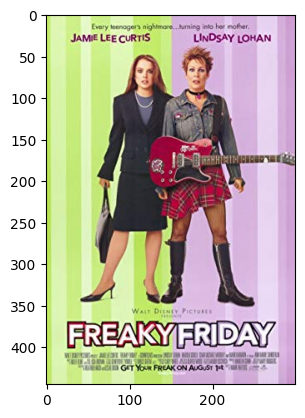

In [25]:
display(movies_train.iloc[1498]['img_path'])

## Set up the multi-label one-hot encoding

In [26]:
NUM_CLASSES = len(mlb_train.classes_)
total = len(movies_train)
# calculate the unumber of negative samples of each class
negative = [0] * NUM_CLASSES
for i in range(total):
    for j in range(NUM_CLASSES):
        if movies_train.iloc[i]['genre_one-hot'][j] == 0:
            negative[j] += 1

weight = [negative[i] / (total - negative[i]) for i in range(NUM_CLASSES)]
WEIGHT = torch.FloatTensor(weight).cuda()
WEIGHT

tensor([ 3.5233, 11.9655,  6.8950,  2.2206,  1.4180, 10.3939,  7.0428,  4.3619],
       device='cuda:0')

### Set up the word embedding model: XLNet

In [27]:
word_embedding_model = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(word_embedding_model)
word_model = AutoModel.from_pretrained(word_embedding_model).to(device)

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Text tokenization

In [28]:
train_tokenized = tokenizer(movies_train['title'].tolist(), padding=True, return_tensors="pt")

tokenizer_keys = list(train_tokenized.keys())
print(tokenizer_keys)

MAX_SEQ_LEN = train_tokenized[list(train_tokenized.keys())[0]][0].shape[0]
print(MAX_SEQ_LEN)

test_tokenized = tokenizer(movies_test_drop_img['title'].tolist(), 
                           padding='max_length',
                           truncation=True,
                           max_length=MAX_SEQ_LEN, 
                           return_tensors='pt')

['input_ids', 'token_type_ids', 'attention_mask']
36


In [29]:
for key in tokenizer_keys:
    movies_train[f'title_{key}'] = train_tokenized[key].tolist()
    movies_test_drop_img[f'title_{key}'] = test_tokenized[key].tolist()

movies_train.head()

,movieid,genre,img,title,genre_one-hot,img_path,title_input_ids,title_token_type_ids,title_attention_mask
0,1,"[Children's, Children's, Comedy]",1.jpg,Toy Story (1995),"[0, 0, 1, 1, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[Adventure, Children's, Children's]",2.jpg,Jumanji (1995),"[0, 1, 1, 0, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[Comedy, Romance]",3.jpg,Grumpier Old Men (1995),"[0, 0, 0, 1, 0, 0, 1, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,"[Comedy, Drama]",4.jpg,Waiting to Exhale (1995),"[0, 0, 0, 1, 1, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,[Comedy],5.jpg,Father of the Bride Part II (1995),"[0, 0, 0, 1, 0, 0, 0, 0]",/kaggle/input/cerenote/content/dataset/ml1m-im...,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Set up the image model ResNet

Mean and standard deviation of the images model

In [30]:
mean = [0.485, 0.456, 0.406] # resnet mean
std = [0.229, 0.224, 0.225] # resnet std

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.Resize((224, 224))
])

## The multi-modal dataset

In [31]:
class MultimodalDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.data = df
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        movieid = self.data.iloc[idx]['movieid']

        title_input_ids = torch.tensor(self.data.iloc[idx]['title_input_ids'])
        title_token_type_ids = torch.tensor(self.data.iloc[idx]['title_token_type_ids'])
        title_attention_mask = torch.tensor(self.data.iloc[idx]['title_attention_mask'])

        img_name = self.data.loc[idx]['img_path']
        if img_name is None:
            image = torch.zeros((3, 224, 224)).float()
        else:
            image = cv2.imread(img_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                image = self.transform(image)

        genre = self.data.loc[idx]['genre_one-hot']
        genre = torch.Tensor(genre)
        
        return movieid, title_input_ids, title_token_type_ids, title_attention_mask, image, genre

### Dataset and DataLoader

In [32]:
train_ds = MultimodalDataset(movies_train, transform)
test_ds = MultimodalDataset(movies_test_drop_img, transform)

In [33]:
train_size = int(0.8 * len(train_ds))
validate_size = len(train_ds) - train_size
train_ds, val_ds = torch.utils.data.random_split(train_ds, [train_size, validate_size])

print(f'Train size: {len(train_ds)} - Validate size: {len(val_ds)} - Test size: {len(test_ds)}')

Train size: 2406 - Validate size: 602 - Test size: 654


In [34]:
BATCH_SIZE = 12
# create data loaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
for movieid, title_input_ids, title_token_type_ids, title_attention_mask, image, genre in train_dl:
    print(title_input_ids.shape, title_token_type_ids.shape, title_attention_mask.shape, image.shape, genre.shape)
    break
for movieid, title_input_ids, title_token_type_ids, title_attention_mask, image, genre in test_dl:
    print(title_input_ids.shape, title_token_type_ids.shape, title_attention_mask.shape, image.shape, genre.shape)
    break

torch.Size([12, 36]) torch.Size([12, 36]) torch.Size([12, 36]) torch.Size([12, 3, 224, 224]) torch.Size([12, 8])
torch.Size([12, 36]) torch.Size([12, 36]) torch.Size([12, 36]) torch.Size([12, 3, 224, 224]) torch.Size([12, 18])


## The multi-modal deep neural network model

In [36]:
import torch.nn.functional as F

class BaseModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, embedding_dimension=3898, hidden_size=128, in_channels=3):
        super(BaseModel, self).__init__()
        self.hidden_size = hidden_size

        # text
        self.bert_output_dim = word_model.config.hidden_size
        self.bert_embed = nn.Sequential(
            nn.Linear(self.bert_output_dim, self.hidden_size),
            nn.ReLU(),
            nn.Dropout(0.2)
#             nn.Linear(self.hidden_size, num_classes),
        )
        
        # IMAGE VGG16
        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2)
#             nn.Linear(self.hidden_size, num_classes)
        )
        
        # fusion
        self.fusion = nn.Linear(self.hidden_size*2, num_classes)
            
    def forward(self, input_ids, token_type_ids, attention_mask, img_tens):
        # IMAGE
        img_feat = self.vgg16.features(img_tens)
        img_feat = self.vgg16.avgpool(img_feat) # for vgg
        img_feat = torch.flatten(img_feat, 1) 
        img_feat = self.vgg16.classifier(img_feat)
        
        # TEXT
        title_tokenized = {
            'input_ids': input_ids,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask
        }
        title_embedding = word_model(**title_tokenized)['last_hidden_state'].cuda()
        title_features = title_embedding[:, 0, :]
        title_features = self.bert_embed(title_features)

        # FUSION
        out = self.fusion(torch.concat([img_feat, title_features], dim=1))
        out = torch.sigmoid(out)
        
#         print(out.shape)
        
        return out

Early stopping

In [37]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Train and validation

In [39]:
def train_and_validate(model, optimizer, loss_func, train_losses, val_losses, scheduler):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    for batch_idx, (movieid, title_input_ids, title_token_type_ids, title_attention_mask, images, targets) in enumerate(train_dl):
        if torch.cuda.is_available():
            images, targets = images.cuda(), targets.cuda().float()
            title_input_ids, title_token_type_ids, title_attention_mask = title_input_ids.cuda(), title_token_type_ids.cuda(), title_attention_mask.cuda().float()
            
        outputs = model(title_input_ids, title_token_type_ids, title_attention_mask, images).cuda()
        
        loss = loss_func(outputs, targets)
#         mix_loss = mixup_loss(loss_func, outputs, y1, y2, l)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        running_loss += loss.item()

    train_loss = running_loss / len(train_dl)
    train_losses.append(train_loss)

    print(f"Train Loss {train_loss:.4f}")

    ## validate

    model.eval()
    running_loss, correct = 0.0, 0
    with torch.no_grad():
        for batch_ind, (movieid, title_input_ids, title_token_type_ids, title_attention_mask, images, targets) in enumerate(val_dl):
            if torch.cuda.is_available():
                images, targets = images.cuda(), targets.cuda().float()
                title_input_ids, title_token_type_ids, title_attention_mask = title_input_ids.cuda(), title_token_type_ids.cuda(), title_attention_mask.cuda()

            outputs = model(title_input_ids,title_token_type_ids, title_attention_mask, images).cuda()
            loss = loss_func(outputs, targets)

            running_loss += loss.item()

    val_loss = running_loss / len(val_dl)
    val_losses.append(val_loss)

#     scheduler.step(val_loss)

    print(f"Val loss: {val_loss:>4f} \n")

## Training configuration, hyperparameters, optimizer, and training loop

In [40]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

model = BaseModel()
learning_rate = 5e-4
epochs = 20
train_losses, val_losses = [], []
epoch_list = list(range(1, epochs + 1))

loss_func = nn.BCELoss(weight=WEIGHT)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
early_stopper = EarlyStopper(patience=3, min_delta=1e-2)

if torch.cuda.is_available():
    model.to(device)

for epoch in epoch_list:
    print(f"Starting epoch: {epoch} / {epochs}")
    train_and_validate(model, optimizer, loss_func, train_losses, val_losses, scheduler)
    scheduler.step()
    if early_stopper.early_stop(val_losses[-1]):
        break

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 302MB/s]


Starting epoch: 1 / 20
Train Loss 2.3686
Val loss: 2.234825 

Starting epoch: 2 / 20
Train Loss 2.2088
Val loss: 2.266712 

Starting epoch: 3 / 20
Train Loss 2.1404
Val loss: 2.208244 

Starting epoch: 4 / 20
Train Loss 2.0947
Val loss: 2.206496 

Starting epoch: 5 / 20
Train Loss 2.0556
Val loss: 2.179151 

Starting epoch: 6 / 20
Train Loss 1.9351
Val loss: 2.179960 

Starting epoch: 7 / 20
Train Loss 1.9214
Val loss: 2.175058 

Starting epoch: 8 / 20
Train Loss 1.9014
Val loss: 2.177080 

Starting epoch: 9 / 20
Train Loss 1.8943
Val loss: 2.179235 

Starting epoch: 10 / 20
Train Loss 1.8859
Val loss: 2.177658 

Starting epoch: 11 / 20
Train Loss 1.8647
Val loss: 2.175712 

Starting epoch: 12 / 20
Train Loss 1.8566
Val loss: 2.175435 

Starting epoch: 13 / 20
Train Loss 1.8694
Val loss: 2.175321 

Starting epoch: 14 / 20
Train Loss 1.8669
Val loss: 2.174993 

Starting epoch: 15 / 20
Train Loss 1.8697
Val loss: 2.175222 

Starting epoch: 16 / 20
Train Loss 1.8591
Val loss: 2.175138 

S

Training loss figure

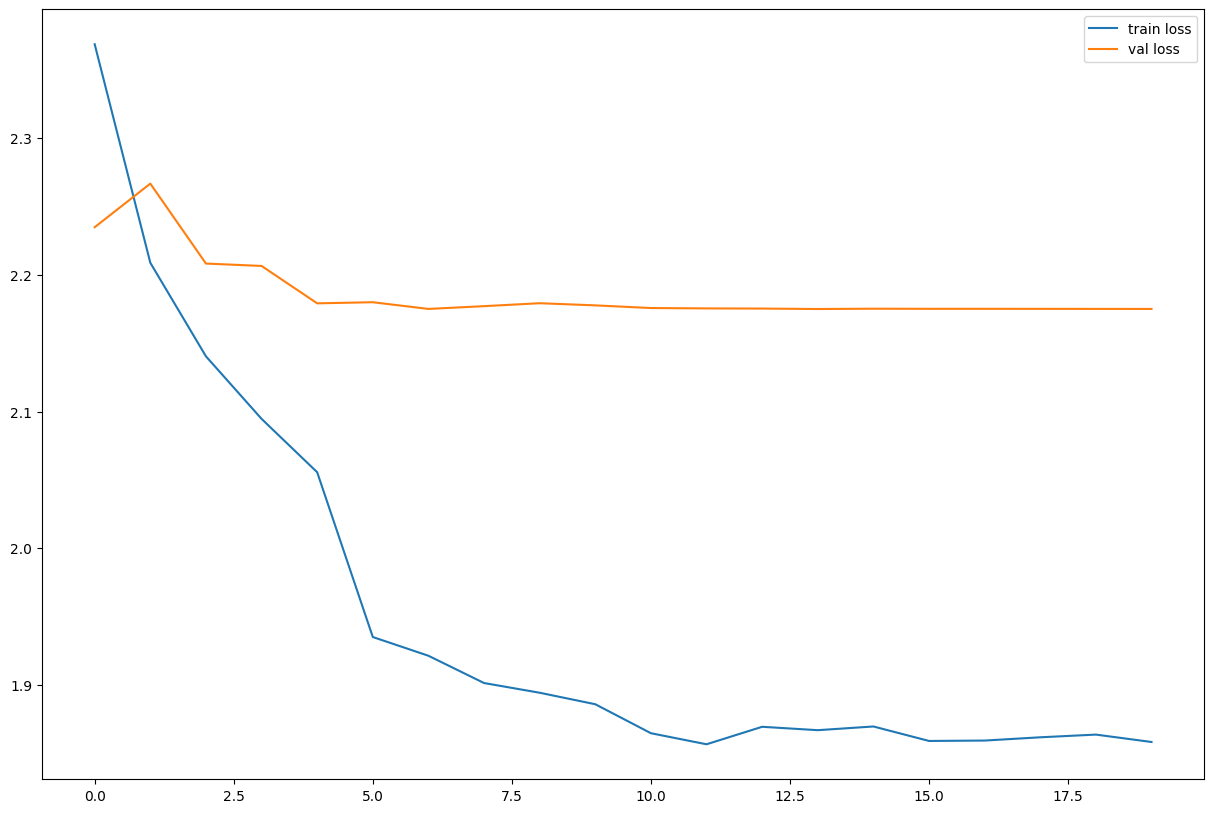

In [41]:
plt.figure(figsize=(15, 10))
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()

plt.savefig('poster-group.png')

## Predict on the testing set

In [42]:
model.eval()
out = []

with torch.no_grad():
    for batch_idx, (movieids, title_input_ids, title_token_type_ids, title_attention_mask, images, targets) in enumerate(test_dl):
        if torch.cuda.is_available():
            images = images.cuda()
            title_input_ids, title_token_type_ids, title_attention_mask = title_input_ids.cuda(), title_token_type_ids.cuda(), title_attention_mask.cuda()

        outputs = model(title_input_ids, title_token_type_ids, title_attention_mask, images).cuda()

        for i in range(len(outputs)):
            movieid = movieids[i].cpu().numpy()
            output = outputs[i].cpu().numpy().astype(float)
            ground_truth = targets[i].cpu().numpy()

            save = {'movieid': movieid, 
                    'output': output, 
                    'ground truth': ground_truth}
            out.append(save)

out_df = pd.DataFrame(out)
out_df.to_csv('fusion-group-early-fusion.csv', index=False)
out_df.head()

,movieid,output,ground truth
0,3397,"[0.4178418815135956, 0.16392181813716888, 0.37...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2067,"[0.2978953421115875, 0.08969952166080475, 0.31...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
2,2651,"[0.15858282148838043, 0.06849908083677292, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,2989,"[0.12082686275243759, 0.018119150772690773, 0....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3415,"[0.04425060749053955, 0.0159665085375309, 0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


### Get final predictions from the output

In [43]:
threshold = 0.15

def final_pred(outputs):
    outputs = np.array(outputs) 
    prediction = (outputs >= threshold).astype(int)
    # if the prediction is all 0s, set 1 for the highest score of outputs
    if prediction.sum() == 0:
        prediction[outputs.argmax()] = 1
    return prediction

out_df['final'] = out_df['output'].apply(lambda x: final_pred(x))
out_df.head()

,movieid,output,ground truth,final
0,3397,"[0.4178418815135956, 0.16392181813716888, 0.37...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 0, 1]"
1,2067,"[0.2978953421115875, 0.08969952166080475, 0.31...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1, 0, 1, 1, 1, 0, 0, 0]"
2,2651,"[0.15858282148838043, 0.06849908083677292, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 1, 1, 1, 1, 0, 0]"
3,2989,"[0.12082686275243759, 0.018119150772690773, 0....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 1, 1, 0, 1, 0]"
4,3415,"[0.04425060749053955, 0.0159665085375309, 0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 1, 1, 1, 0, 0]"


In [44]:
out_df['pred'] = out_df['ground truth'].apply(lambda x: [0 for i in range(len(x))])

## Ungroup the labels

In [45]:
def ungroup(row):
    row['pred'][0] = row['final'][0]
    row['pred'][1] = row['final'][1]
    row['pred'][2], row['pred'][11], row['pred'][8], row['pred'][6] = row['final'][2], row['final'][2], row['final'][2], row['final'][2]
    row['pred'][9], row['pred'][5], row['pred'][12] = row['final'][7], row['final'][7], row['final'][7]
    row['pred'][14], row['pred'][16], row['pred'][17] = row['final'][0], row['final'][0], row['final'][0]
    row['pred'][3] = row['final'][2]
    row['pred'][4] = row['final'][3]
    row['pred'][7] = row['final'][4]
    row['pred'][10] = row['final'][5]
    row['pred'][13] = row['final'][6]
    row['pred'][15] = row['final'][7]

    return row

out_df = out_df.apply(lambda x: ungroup(x), axis=1)
out_df.head()

,movieid,output,ground truth,final,pred
0,3397,"[0.4178418815135956, 0.16392181813716888, 0.37...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 1, 1, 1, 0, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,2067,"[0.2978953421115875, 0.08969952166080475, 0.31...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[1, 0, 1, 1, 1, 0, 0, 0]","[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, ..."
2,2651,"[0.15858282148838043, 0.06849908083677292, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 0, 1, 1, 1, 1, 0, 0]","[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, ..."
3,2989,"[0.12082686275243759, 0.018119150772690773, 0....","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0, 0, 1, 1, 0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,3415,"[0.04425060749053955, 0.0159665085375309, 0.03...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0, 0, 0, 1, 1, 1, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."


In [46]:
out_df['movieid'] = out_df['movieid'].astype('int')

In [47]:
movies_test['movieid'].dtype, out_df['movieid'].dtype

(dtype('int64'), dtype('int64'))

In [48]:
movies_test_merge = movies_test.merge(out_df,on='movieid', how='left',)
movies_test_merge = movies_test_merge.drop(columns=['output', 'ground truth', 'final'])
movies_test_merge.head()

,movieid,title,genre,img,pred
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ..."
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067.jpg,"[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, ..."
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651.jpg,"[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, ..."
3,2989,For Your Eyes Only (1981),[Action],2989.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ..."


For movies without poster images, we predict the genres based on the movies' year.

In [49]:
movies_train['year'] = movies_train['title'].apply(lambda x: x[-5:-1]).astype('int')
movies_test_merge['year'] = movies_test_merge['title'].apply(lambda x: x[-5:-1]).astype('int')

def get_genre_by_year(year):
#     print(year)
    year_genres = movies_train[movies_train['year'] == year]['genre'].explode().value_counts()
    if len(year_genres) == 0:
        return 'Drama'
    return year_genres.index[0]

get_genre_by_year(1919)

'Adventure'

In [50]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(movies_test['genre'])

mlb.classes_

array(['Action', 'Adventure', 'Animation', "Children's", 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western'], dtype=object)

Merge movies with no poster images back to the testing set

In [51]:
movies_test_merge['pred'] = movies_test_merge.apply(lambda x: mlb.transform(get_genre_by_year(x['year']))[0] if type(x['pred']) != list else x['pred'], axis=1)
movies_test_merge

,movieid,title,genre,img,pred,year
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",1981
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067.jpg,"[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, ...",1965
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651.jpg,"[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",1943
3,2989,For Your Eyes Only (1981),[Action],2989.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",1981
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",1975
...,...,...,...,...,...,...
772,2309,"Inheritors, The (Die Siebtelbauern) (1998)",[Drama],2309.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1998
773,2421,"Karate Kid, Part II, The (1986)","[Action, Adventure, Drama]",2421.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...",1986
774,3255,"League of Their Own, A (1992)","[Comedy, Drama]",3255.jpg,"[0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, ...",1992
775,974,Algiers (1938),"[Drama, Romance]",974.jpg,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, ...",1938


In [52]:
movies_test_merge['golden_one_hot'] = movies_test_merge['genre'].apply(lambda x: mlb.transform([x])[0])
movies_test_merge.head()

,movieid,title,genre,img,pred,year,golden_one_hot
0,3397,"Great Muppet Caper, The (1981)","[Children's, Comedy]",3397.jpg,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, ...",1981,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2067,Doctor Zhivago (1965),"[Drama, Romance, War]",2067.jpg,"[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, ...",1965,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
2,2651,Frankenstein Meets the Wolf Man (1943),[Horror],2651.jpg,"[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, ...",1943,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,2989,For Your Eyes Only (1981),[Action],2989.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...",1981,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3415,"Mirror, The (Zerkalo) (1975)",[Drama],3415.jpg,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...",1975,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


### Final classification report

In [53]:
from sklearn.metrics import classification_report

print(classification_report(movies_test_merge['golden_one_hot'].tolist(), 
                            movies_test_merge['pred'].tolist(),
                            digits=4,
                            target_names=mlb.classes_))

              precision    recall  f1-score   support

      Action     0.1352    0.7333    0.2284        90
   Adventure     0.1552    0.1875    0.1698        48
   Animation     0.0474    0.4286    0.0853        21
  Children's     0.1158    0.4583    0.1849        48
      Comedy     0.3374    0.8907    0.4894       247
       Crime     0.0465    0.5806    0.0861        31
 Documentary     0.0263    0.1667    0.0455        30
       Drama     0.3798    0.8026    0.5156       309
     Fantasy     0.0158    0.4286    0.0305         7
   Film-Noir     0.0129    0.8333    0.0254         6
      Horror     0.2857    0.4267    0.3422        75
     Musical     0.0263    0.3846    0.0493        13
     Mystery     0.0310    0.6667    0.0593        18
     Romance     0.1758    0.3085    0.2239        94
      Sci-Fi     0.0758    0.7708    0.1381        48
    Thriller     0.1938    0.7075    0.3043       106
         War     0.0328    0.6400    0.0624        25
     Western     0.0184    